Deep Convolutional Variational Autoencoder with Fashion MNIST
===



# Setup

In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    datasets,
    callbacks,
    losses,
    optimizers,
    metrics,
)

from scipy.stats import norm

In [2]:
# @title utility function to render image
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

In [3]:
def display(images, n=10, size=(20, 3), cmap="gray_r", as_type="float32"):
    """
    Displays n of the given image arrays.
    """
    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    plt.show()

# Parameters

In [4]:
IMAGE_SIZE = 32
BATCH_SIZE = 100
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 5
BETA = 10 # 500
LEARNING_RATE = 0.0005

# Training Data

In [5]:
# @title Load
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [6]:
# @title Conform tf.data.Dataset
%%time

# Create TensorFlow datasets from NumPy arrays
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# normalization for batch data
def normalize(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.expand_dims(image, -1)
    image = tf.pad(image, ((0, 0), (2, 2), (2, 2), (0, 0)), constant_values=0.0)
    print(image.shape)
    return image, label

# Apply normalization and batch the datasets
train_dataset_normalized = train_dataset.prefetch(
    tf.data.AUTOTUNE).shuffle(buffer_size=1024).batch(
        BATCH_SIZE).map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset_normalized = test_dataset.batch(BATCH_SIZE).map(normalize)

Cause: Unable to locate the source code of <function normalize at 0x7dbca22a0160>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function normalize at 0x7dbca22a0160>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(None, 32, 32, 1)
(None, 32, 32, 1)
CPU times: user 128 ms, sys: 65.5 ms, total: 194 ms
Wall time: 338 ms


(100, 32, 32, 1)


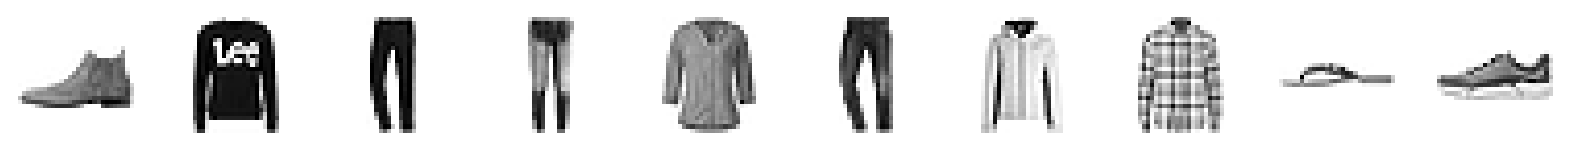

In [7]:
def display_dataset(dataset):
    for image, label in dataset.take(1):
        print(image.shape)
        plt.figure(figsize=(20,3))
        n = 10

        for i in range(n):
            _ = plt.subplot(1, n, i + 1)
            plt.imshow(image[i].numpy(), cmap='gray_r')
            plt.axis("off")
display_dataset(test_dataset_normalized)

# Construct Variational Autoencoder


In [51]:
# @title Sampling Layer

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim)) # 平均から離す距離。標準正規分布からサンプリング。
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 32, 32, 1)]          0         []                            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 16, 16, 32)           320       ['encoder_input[0][0]']       
                                                                                                  
 conv2d_7 (Conv2D)           (None, 8, 8, 64)             18496     ['conv2d_6[0][0]']            
                                                                                                  
 conv2d_8 (Conv2D)           (None, 4, 4, 128)            73856     ['conv2d_7[0][0]']            
                                                                                            

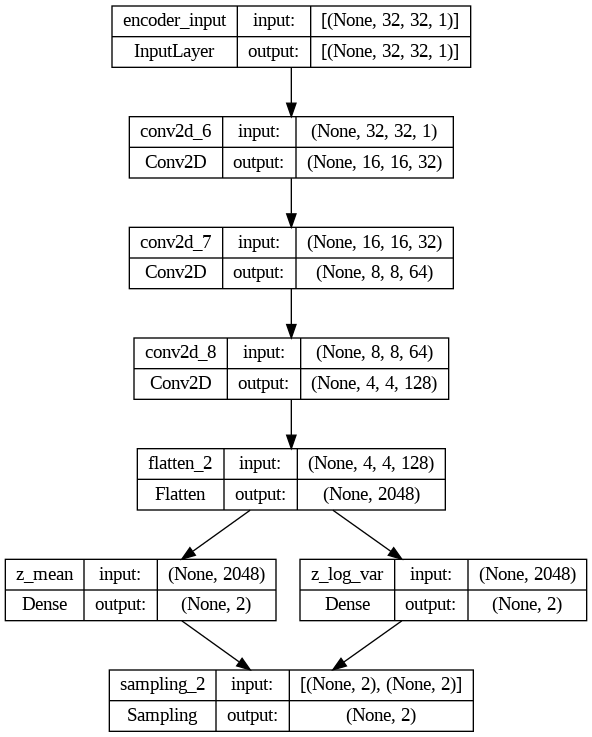

In [52]:
# @title Encoder
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, 1), name="encoder_input"
)
# 32x32x1 -> 16x16x32
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(
    encoder_input
)
# 16x16x32 -> 8x8x64
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
# 8x8x64 -> 4x4x128
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
# 4x4x128 -> 2048
shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this!

x = layers.Flatten()(x)

### extended for VAE
# 2048 -> 4098
z_mean = layers.Dense(EMBEDDING_DIM, name="z_mean")(x)
# 2048 -> 4098
z_log_var = layers.Dense(EMBEDDING_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
###

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
print(encoder.summary())
tf.keras.utils.plot_model(encoder, show_shapes=True)


In [53]:
# Decoder
decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    64, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    32, (3, 3), strides=2, activation="relu", padding="same"
)(x)
decoder_output = layers.Conv2D(
    1,
    (3, 3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",
)(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense_2 (Dense)             (None, 2048)              6144      
                                                                 
 reshape_2 (Reshape)         (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose_6 (Conv2D  (None, 8, 8, 128)         147584    
 Transpose)                                                      
                                                                 
 conv2d_transpose_7 (Conv2D  (None, 16, 16, 64)        73792     
 Transpose)                                                      
                                                                 
 conv2d_transpose_8 (Conv2D  (None, 32, 32, 32)        1846

In [54]:
# @title VAE

class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

        # メトリクスの履歴を保存するトラッカー
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    def get_config(self):
        config = super(VAE, self).get_config()
        config.update({
            'encoder': self.encoder,
            'decoder': self.decoder,
        })
        return config

    @classmethod
    def from_config(cls, config):
        encoder = config.pop('encoder')
        decoder = config.pop('decoder')
        return cls(encoder, decoder, **config)

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """Call the model on a particular input."""
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """Step run during training."""
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            # reconstruction loss
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                BETA * tf.square(data - reconstruction),
                axis=[1,2,3]
                )
            )
            # KL loss
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # メトリクスをアップデート
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)

        # reconstruction loss
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                BETA * tf.square(data - reconstruction),
                axis=(1, 2, 3),
            )
        )
        # KL loss
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

# Train VAE

In [55]:
# @title instantiate VAE
vae = VAE(encoder, decoder)

In [56]:
# @title Compile VAE
optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
vae.compile(optimizer=optimizer)

In [57]:
# @title Train

# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint",
    save_weights_only=False,
    save_freq="epoch",
    monitor="total_loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

vae.fit(
    train_dataset_normalized.map(lambda image, label: image), # 入力画像を正解値として学習させる,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=test_dataset_normalized.map(lambda image, label: image),
    callbacks=[model_checkpoint_callback, tensorboard_callback],
)

Epoch 1/5
600/600 [==============================] - 12s 16ms/step - total_loss: 459.3007 - reconstruction_loss: 450.7073 - kl_loss: 8.5935 - val_loss: 307.3958 - val_reconstruction_loss: 299.5408 - val_kl_loss: 7.8550
Epoch 2/5
600/600 [==============================] - 8s 14ms/step - total_loss: 273.0636 - reconstruction_loss: 265.3795 - kl_loss: 7.6842 - val_loss: 278.2788 - val_reconstruction_loss: 270.7038 - val_kl_loss: 7.5750
Epoch 3/5
600/600 [==============================] - 9s 15ms/step - total_loss: 258.5568 - reconstruction_loss: 250.9625 - kl_loss: 7.5943 - val_loss: 266.9071 - val_reconstruction_loss: 259.2632 - val_kl_loss: 7.6440
Epoch 4/5
600/600 [==============================] - 9s 15ms/step - total_loss: 249.8663 - reconstruction_loss: 242.2785 - kl_loss: 7.5877 - val_loss: 263.5215 - val_reconstruction_loss: 256.0435 - val_kl_loss: 7.4780
Epoch 5/5
600/600 [==============================] - 8s 14ms/step - total_loss: 243.9583 - reconstruction_loss: 236.3578 - kl_l

In [58]:
# @title Export the models
vae.save("./models/vae")
encoder.save("./models/encoder")
decoder.save("./models/decoder")

In [9]:
# @title Mount Gdrive
from google.colab import drive
drive.mount('/content/drive')

dpath_saved_models = Path('/content/drive/MyDrive/Colab Notebooks/my/GenFashionImage/models/deep-convolutional-vae/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
# @title Export to GDrive
vae.save(dpath_saved_models / "vae")
encoder.save(dpath_saved_models / "encoder")
decoder.save(dpath_saved_models / "decoder")

In [10]:
# @title Reload the saved models
vae = models.load_model(dpath_saved_models / "vae")
encoder = models.load_model(dpath_saved_models / "encoder")
decoder = models.load_model(dpath_saved_models / "decoder")

# Reconstruct using the VAE

In [11]:
n_batch_to_predict = 50
test_sub_dataset = test_dataset_normalized.take(n_batch_to_predict)
example_images = []
example_labels = []
for images,labels in test_sub_dataset:
    example_images.append(images)
    example_labels.append(labels)
example_images = tf.concat(example_images, axis=0)
example_labels = tf.concat(example_labels, axis=0)
print(example_images.shape)
print(example_labels.shape)

(5000, 32, 32, 1)
(5000,)


157/157 [==============================] - 5s 33ms/step
Some original examples


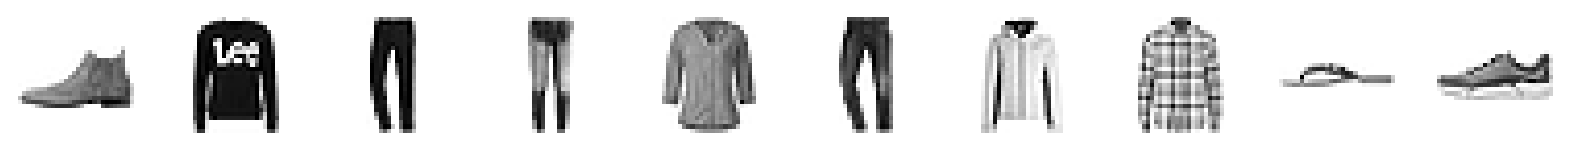

Reconstructions


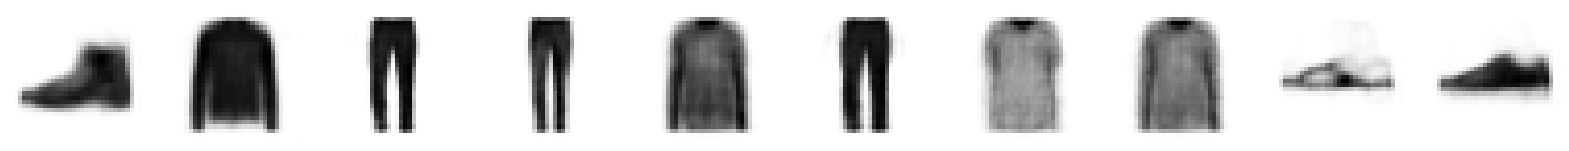

In [12]:
# Create autoencoder predictions and display
example_images = example_images.numpy()
z_mean, z_log_var, reconstructions = vae.predict(example_images)
print("Some original examples")
display(example_images)
print("Reconstructions")
display(reconstructions)

# Embed using the encoder

In [13]:
# Encode the example images
z_mean, z_var, z = encoder.predict(example_images)

157/157 [==============================] - 1s 6ms/step


In [14]:
# Some examples of the embeddings
print(z[:10])

[[-1.0562665e+00  1.3247694e+00]
 [ 1.5464190e-01 -2.8498405e-01]
 [ 3.5671878e+00 -9.3930286e-01]
 [ 3.5592525e+00  3.9557362e-01]
 [ 4.8930448e-01  5.0255835e-01]
 [ 2.6643131e+00 -8.8244081e-01]
 [ 8.6452115e-01  1.2759340e+00]
 [ 5.6273437e-01  9.4704825e-01]
 [ 2.2055786e-03  2.7707469e+00]
 [-3.8219717e-01  1.9754976e+00]]


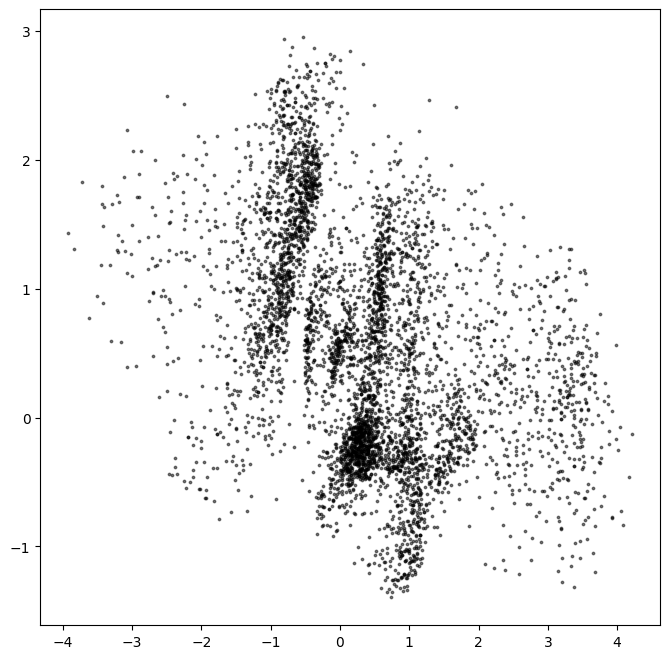

In [15]:
# Show the encoded points in 2D space
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=3)
plt.show()

# Generate using the decoder

In [16]:
# @title Sampling from the latent space

# Sample some points in the latent space from standard normal distribution
grid_width, grid_height = (6, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, 2))
z_sample.shape

(18, 2)

In [17]:
# @title Decode the sampled points
reconstructions = decoder.predict(z_sample)

1/1 [==============================] - 0s 120ms/step


In [18]:
# @title Convert original embeddings and sampled embeddings to p-values
p = norm.cdf(z)
p_sample = norm.cdf(z_sample)

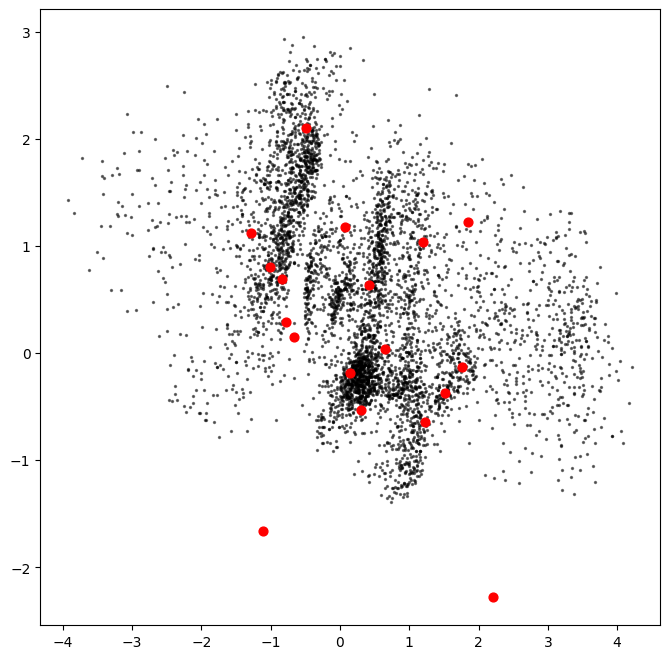

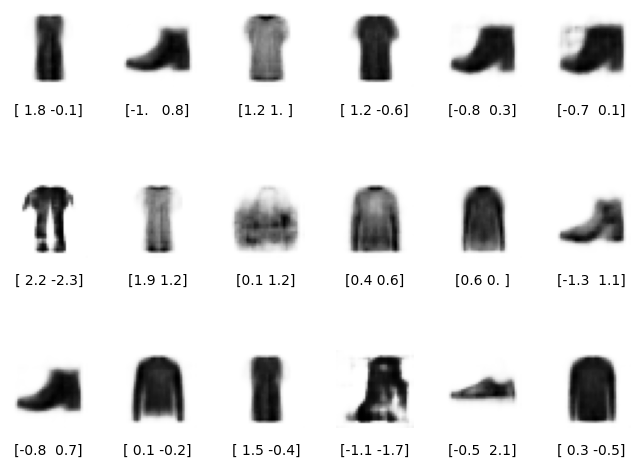

In [19]:
# @title Render the reconstructed images of the sampled embeddings
figsize = 8
plt.figure(figsize=(figsize, figsize))

# embeddings
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=2)

# sampled points in the latent space
plt.scatter(z_sample[:, 0], z_sample[:, 1], c="#FF0000", alpha=1, s=40)
plt.show()

# Show the decoded images as grid in the bottom
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(z_sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

# Investigate the obtained embeddings

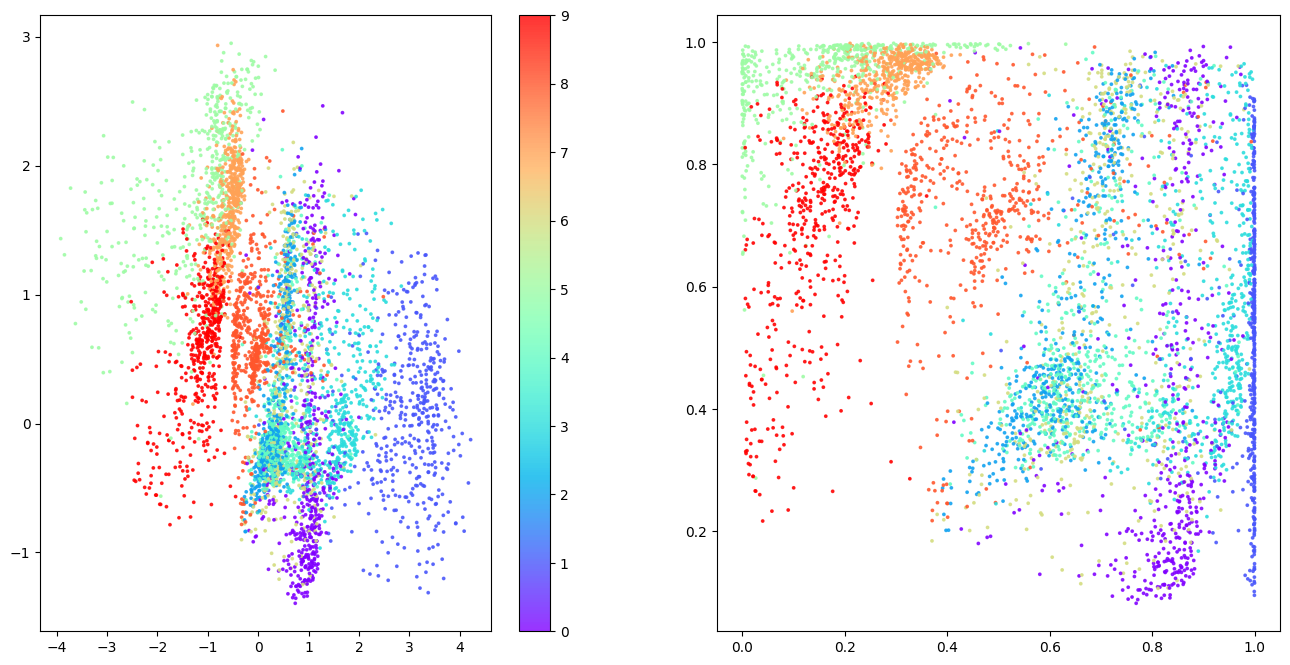

In [20]:
# Colorize the embeddings with their labels
figsize = 8
fig = plt.figure(figsize=(figsize * 2, figsize))

ax = fig.add_subplot(1, 2, 1)
plot_1 = ax.scatter(
    z[:, 0], z[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.colorbar(plot_1)

ax = fig.add_subplot(1, 2, 2)
plot_2 = ax.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.show()

| ID | Clothing Label |
| :- | :- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

8/8 [==============================] - 0s 25ms/step


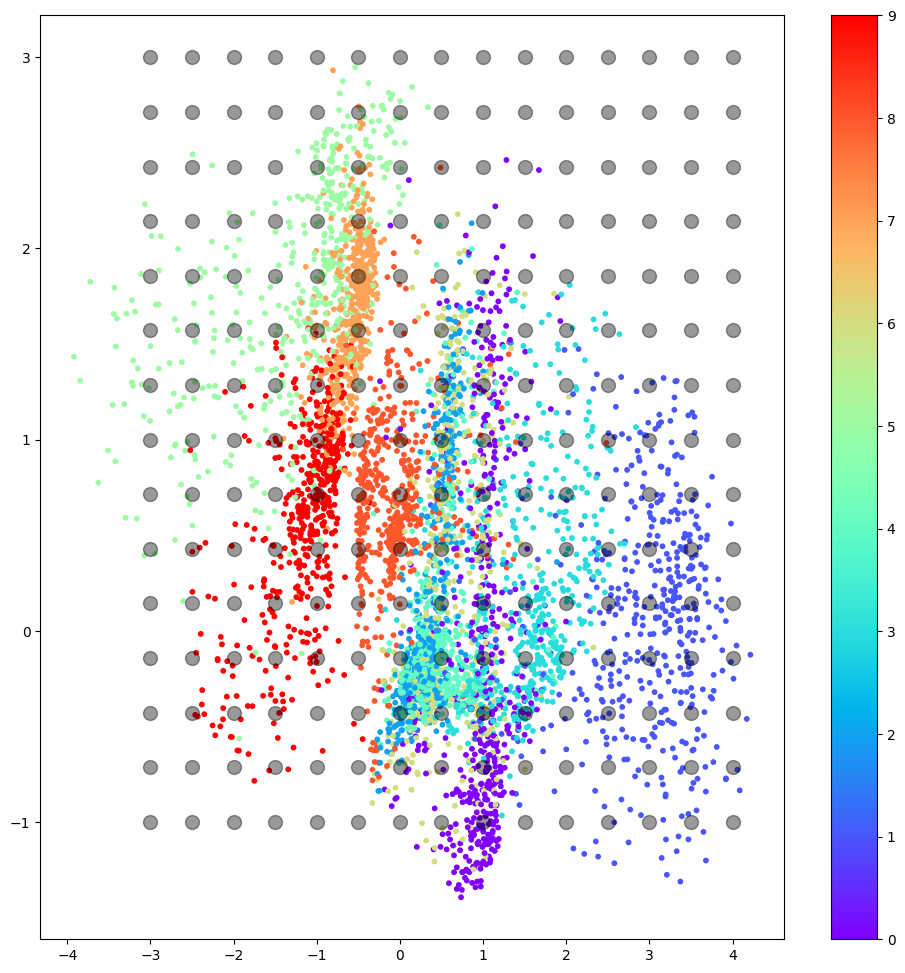

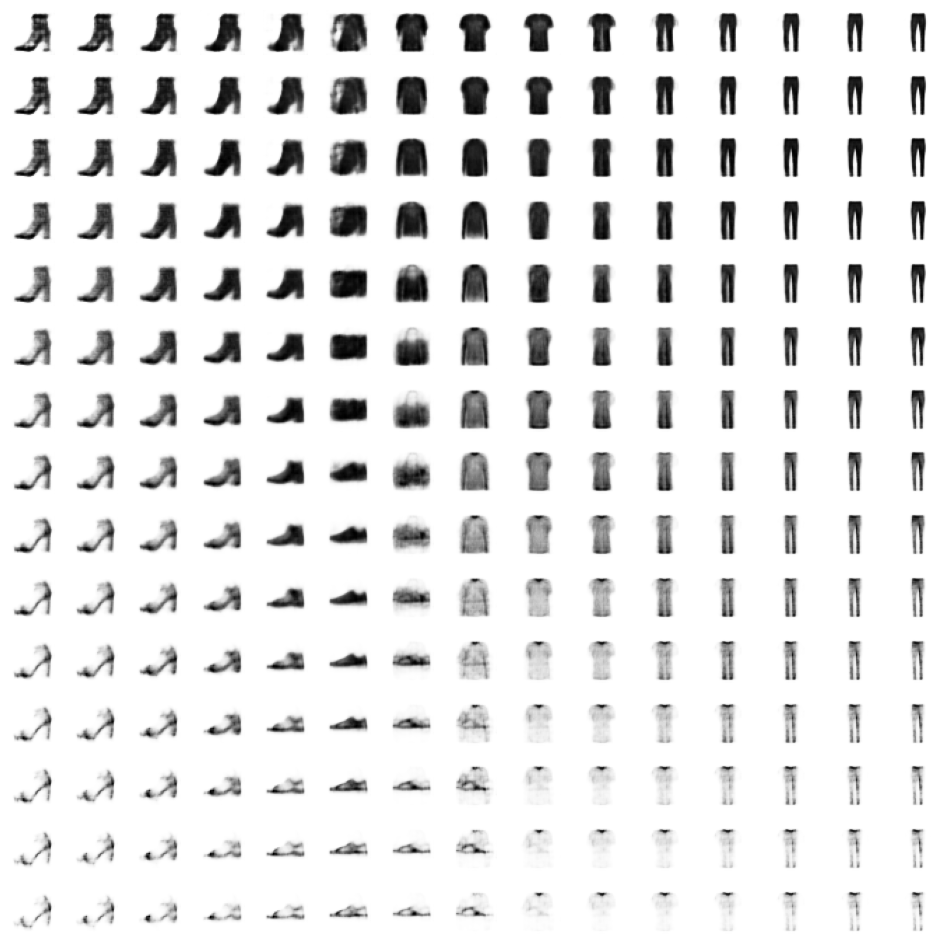

In [21]:
# Colorize embeds by label classes
figsize = 12
grid_size = 15

plt.figure(figsize=(figsize, figsize))
plt.scatter(
    z[:, 0], z[:, 1], cmap="rainbow", c=example_labels, alpha=1.0, s=10
)
plt.colorbar()

# make grid data
x = tf.linspace(-3.0, 4.0, grid_size)
y = tf.linspace(-1.0, 3.0, grid_size)
X, Y = tf.meshgrid(x, y)
# concatenate the coordinates into a single tensor
grid = tf.concat([tf.reshape(X, [-1, 1]), tf.reshape(Y, [-1, 1])], axis=1)
plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=0.4, s=100)

# reconstruct with the grid data
reconstructions = decoder.predict(grid)

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")